In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# import simpreglib as srl
import pandas as pd
import numpy as np
import datetime as dt

# for linear regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats

# run_RFE and run_RFECV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [38]:
# creates dictionary of variance inflation factors. 
def create_vif_dictionary(X):

    vif_dict = {}
    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):
    adj_R_squares = {}
    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 


                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

def run_RFE(X,y):
    linreg = LinearRegression()
    selector = RFE(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

def run_RFECV(X,y):
    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    return selections, rankers

def run_OLS_model(X,y):
    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()
    return model

Set up predictor and target dataframes, deal with unusable data

In [3]:
X = pd.read_csv('data/kc_house_data.csv')
X.drop(X.loc[X['sqft_basement']=='?'].index,inplace=True) # remove '?' from the data.
y = X.price
X.drop(['price','id','zipcode','lat','long'],inplace=True,axis=1)

Engineer data to present as numerical values, not objects. 

In [4]:
# convert all string types into np floats
X.sqft_basement = [float(sq) for sq in list(X.sqft_basement)]

# Replaces grade strings with numerics based on data dict. 
grade_raws = list(X.grade.unique())
# replaces a cell value with the int of the first character of its existing string
for raw in grade_raws:
    X.grade.replace(to_replace=raw,value=int(raw[0]),inplace=True)

# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
for key in condition_dict:
    X.condition.replace(to_replace=condition_dict,inplace=True)

# replace yr_built NaNs with numeric 0
X.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)

In [5]:
# convert waterfront into numeric boolean
waterfront_bool_list = []
for value in X.waterfront:
    if value == 'YES':
        waterfront_bool_list.append(1)
    else:
        waterfront_bool_list.append(0)
X.waterfront = waterfront_bool_list

In [6]:
# convert view from string into categorical ordinal
view_rank_list = [] 
view_dict = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}

for value in X.view:
    if value in list(view_dict.keys()):
        view_rank_list.append(view_dict[value])
    else:
        view_rank_list.append(0)
        
X.view = view_rank_list

Engineer date into a usable type of number (datetime ordinal)

In [7]:
# convert dates into ordinals
X.date = pd.to_datetime(X['date'])
X.date = X['date'].map(dt.datetime.toordinal)

In [8]:
null_dict = {}
for feature in X.columns:
    null_count = sum(X[feature].isna())
    null_dict[feature] = null_count
# null_dict

Investigate multicolinearity before engineering inferred features

In [9]:
# X.corr()
cor_df=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
cor_df.set_index(['pairs'], inplace = True)
cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
cor_df.columns = ['cc']
cor_df.drop_duplicates(inplace=True)

In [10]:
# cor_df[(cor_df.cc>.60) & (cor_df.cc <1)]

In [11]:
# colinear_drops = ['sqft_above','sqft_living15','bathrooms','sqft_lot15']

Engineering inferred feature
- bed bath ratio:           ratio of bedrooms to bathrooms
- level ratios:             ratio of square feet above 'grade' and below (ratio of everything else to the basement)
- live_lot_ratio:           ratio of living space to lot size
- relative living space:    ratio of living space to the living space of the nearest 15 houses (sqft_living :: sqft_living15)
- relatve lot size:         same as living space but for lot size instead. 
- level difference:         difference in square footage of living space to basement space

In [12]:
bbratios = []
lvl_ratios = []
live_lot_ratio = []

for index,row in X.iterrows(): #iterate through every record
#     print(row)
    bbratio = row.bedrooms/row.bathrooms # calculate ratio of bedrooms to bathrooms
    bbratios.append(bbratio) # append ratio to the list

    LLratio = row.sqft_living/row.sqft_lot
    live_lot_ratio.append(LLratio)

    if row.sqft_basement == 0: # sqft_basement is zero if there is no basement
        lvl_ratios.append(0) # ratio should also be zero if there is no ratio
    else:
        lvl_ratio = row.sqft_above / row.sqft_basement # calculate ratio of space above grade vs below grade
        lvl_ratios.append(lvl_ratio) # append ratio to the list

X['bed_bath_ratio'] = bbratios # create new column and asign list as its values
X['level_ratio'] = lvl_ratios # create new column and asign list as its values
X['live_lot_ratio'] = live_lot_ratio # you get the idea . . . 

In [13]:
rel_live_space = []
rel_lot_size = [] 
rel_difference = []

for index,row in X.iterrows(): # for every record 
    live_dif = row.sqft_living - row.sqft_living15 # calculate difference in sqft of the given house and the nearest 15 other houses
    rel_live_space.append(live_dif) # append it to the list

    lot_dif = row.sqft_lot - row.sqft_lot15 # calculate difference in sqft of the given lot and the nearest 15 other lots
    rel_lot_size.append(lot_dif) # append it to the list

    lvl_dif = row.sqft_above - row.sqft_basement # calculate difference between space above grade and below grade
    rel_difference.append(lvl_dif) # append it to the list

X['relative_living_space'] = rel_live_space # assign respective list to new column 
X['relative_lot_size'] = rel_lot_size
X['level_difference'] = rel_difference

In [14]:
# X.columns
# X.info()

In [15]:
cor_df=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
cor_df.set_index(['pairs'], inplace = True)
cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
cor_df.columns = ['cc']
cor_df.drop_duplicates(inplace=True)

In [16]:
cor_df[(cor_df.cc>.60) & (cor_df.cc <1)]

# is it a good decision to drop sqft_living in lieu of relative_living_space ???

,cc
pairs,
"(sqft_above, level_difference)",0.887606
"(sqft_above, sqft_living)",0.876678
"(sqft_living15, sqft_living)",0.756389
"(bathrooms, sqft_living)",0.755278
"(relative_lot_size, sqft_lot)",0.754121
"(sqft_living15, sqft_above)",0.731016
"(sqft_lot, sqft_lot15)",0.720649
"(bathrooms, sqft_above)",0.686456
"(relative_living_space, sqft_living)",0.665513


In [17]:
# columns to drop based one colinearity
co_drops = ['sqft_living','sqft_above','sqft_living15','bathrooms','sqft_lot15','sqft_lot','level_ratio'] # included level ratio since its basically same as level difference

In [18]:
Xd = X.drop(co_drops,axis=1)

- investigage mapping zipcode, or coordinates to view ? Not enough coordinate info... 
- consider dropping zip/lot/long and then re running notebook from the top, (i.e. their presence may affect colinearity of other features?) 
    - did not affect colinearity but it cleaned up some clutter

##### Linear Transformation and Feature ranking 
using standardization (x - x_bar / sigma) to normalize units of measurement

investigate feature rankings using:
- stepwise method
- recursive elimination


In [19]:
Xs = pd.DataFrame([]) # data standardized
for feature in Xd.columns:
    x_comp = (Xd[feature] - np.mean(Xd[feature])/np.std(Xd[feature])) # (x - x_bar)/sigma
    Xs[feature] = x_comp 

In [59]:
Xlog = pd.DataFrame([]) # standardized data log transformed
for feature in Xs.columns:
    x_logged = np.log(Xs[feature])
    Xlog[feature] = x_logged

In [75]:
for column in Xlog:
    Xlog[column].replace(np.NaN,0,inplace=True)

Create a baseline model for refrence

In [76]:
# baseline model 
# standard_model = run_OLS_model(Xs,y)
log_model = run_OLS_model(Xlog,y)


In [58]:
# Q-Q plots 
# for idx,feature in enumerate(Xd.columns):
#     logged = np.log(Xd[feature])
#     sm.qqplot(logged, line ='45')
#     plt.title(feature)

# plt.tight_layout()
# plt.show()

(array([4.5000e+01, 1.3444e+04, 7.2560e+03, 3.2700e+02, 5.2000e+01,
        1.1000e+01, 4.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([-1479558.57251858,  -721266.86776231,    37024.83699395,
          795316.54175022,  1553608.24650648,  2311899.95126275,
         3070191.65601901,  3828483.36077528,  4586775.06553154,
         5345066.77028781,  6103358.47504407]),
 <BarContainer object of 10 artists>)

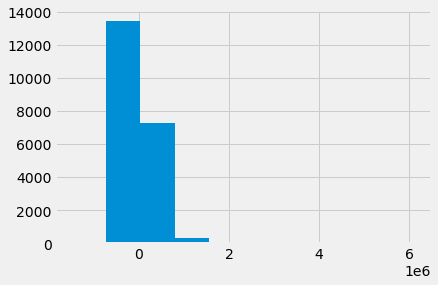

In [78]:
log_residuals = log_model.resid
plt.hist(log_residuals)

Stepwise selection method

In [22]:
stepwisers = stepwise_selection(Xs, y, Xs.columns,threshold_in=0.01, threshold_out = 0.05, verbose=False)
stepwised_df = Xs[stepwisers]

# appears same as baseline 
# print_model(stepwised_df,y)

Recursive elimation: with and without cross-validation

In [28]:
selection, ranked = run_RFE(Xs,y)
RFE_df = Xs[selection] # dataframe containing only features selected by recursive elimination

# absolute garbage
# print_model(RFE_df,y)

In [30]:
selected, ranking = run_RFECV(Xs,y)
RFECV_df = Xs[selected]

# also identtical to baseline 
# print_model(RFECV_df,y)

Manual selection based on P value and variance inflation factor

In [35]:
good,bad = create_vif_dictionary(Xs)

In [37]:
drop_Ps = Xs.drop(['relative_lot_size'],axis=1)
drop_vifs = drop_Ps.drop(bad,axis=1)

# print_model(drop_vifs,y) # trash
